## React Agent

React => **Reasoning** + **Acting**

**Objettive:**
- Learn how to create tools.
- Creating `ReAct graph`
- Work With different message type like `ToolMessage`
- Use ``Annotated`` typing.

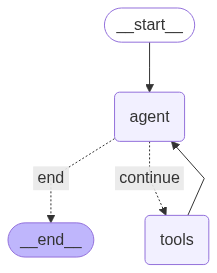

In [12]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

**Imports**

In [1]:
# typing
from typing import Annotated, TypedDict, List, Sequence

# langchain
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage, HumanMessage
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

# langgraph
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode


**Why use Annotation?**
- typing.Annotated
- Describes / annotates a variable. 
- Sort of like, context of a value.
- For more reference: [Typing Docs](https://docs.python.org/3/library/typing.html#typing.Annotated)

In [2]:
email = Annotated[str, 'This has to be email.']

print(email.__metadata__)

('This has to be email.',)


**add_message usage**
- Reducer function
- Merges the state returned from node.
- No need to return all values, just a desirable key and value as a dict.

In [3]:
# without reducer:
state = {"messages": ["Hi"]}
update = {"messages": ["Hello how are you ?"]}
new_state = {"messages": ["Hello how are you ?"]} # no state is appended

# with reducer
state = {"messages": ["Hi"]}
update = {"messages": ["Hello how are you ?"]}
new_state = {"messages": ["Hi","Hello how are you ?"]} # state is appended

In [4]:
!ollama ls

NAME                       ID              SIZE      MODIFIED      
llama3:instruct            365c0bd3c000    4.7 GB    7 weeks ago      
llama3.1:latest            46e0c10c039e    4.9 GB    7 weeks ago      
llama3.2:1b                baf6a787fdff    1.3 GB    2 months ago     
gemma2:latest              ff02c3702f32    5.4 GB    2 months ago     
llama3:8b                  365c0bd3c000    4.7 GB    3 months ago     
nomic-embed-text:latest    0a109f422b47    274 MB    4 months ago     
qwen2.5-coder:1.5b-base    02e0f2817a89    986 MB    4 months ago     
llama3.1:8b                46e0c10c039e    4.9 GB    4 months ago     
sqlcoder:7b                77ac14348387    4.1 GB    5 months ago     
deepseek-r1:latest         0a8c26691023    4.7 GB    5 months ago     
mistral:latest             f974a74358d6    4.1 GB    5 months ago     
llava:latest               8dd30f6b0cb1    4.7 GB    11 months ago    
llama3:latest              365c0bd3c000    4.7 GB    11 months ago    


**Agent State**

In [5]:
# Sequence: https://docs.python.org/3/glossary.html#term-sequence
# Base Message: https://python.langchain.com/api_reference/core/messages/langchain_core.messages.base.BaseMessage.html#basemessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

**Tools:**

In [6]:
@tool
def add(a: int, b:int):
    """This is an addition function that adds 2 numbers together"""

    return a + b 

@tool
def subtract(a: int, b: int):
    """Subtraction function"""
    return a - b

@tool
def multiply(a: int, b: int):
    """Multiplication function"""
    return a * b

tools = [add, subtract, multiply]

**model**

In [7]:
model_name = "llama3.1:latest"

model = ChatOllama(model=model_name).bind_tools(tools=tools)

# model = ChatOpenAI(model=model_name, base_url='http://localhost:11434/v1', api_key='ollama').bind_tools(tools=tools)

**Nodes:**

In [8]:
def model_call(state: AgentState):
    sys_msg = """
        You are a helpful assistant, answer my question based on tools if needed. You have access to tools sum, multiply and subtract.
        Use tools for solving sum, multiply and subtract.
    """
    system_message = SystemMessage(
        content=sys_msg
    )
    response = model.invoke([system_message] + state["messages"])

    # note that, since we re using reducer, we dont need to return all
    return {"messages" : [response]}


def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)

    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"
    

tool_node = ToolNode(tools=tools)

**Graph nodes and edges**

In [9]:
graph = StateGraph(AgentState)

# nodes
graph.add_node('agent', model_call)
graph.add_node("tools", tool_node)

# edges
graph.add_edge(START, 'agent')
graph.add_conditional_edges(
    'agent',
    should_continue,
    {
        "continue": "tools",
        "end": END
    }
)
graph.add_edge('tools', 'agent') # edge from tool to agent



**Compile Graph and Invoke**

In [10]:
agent = graph.compile()

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "Add 12 and 5. From a result subtract 6. Now give me a final result. Tell me a joke about a dog")]}
print_stream(agent.stream(inputs, stream_mode="values"))

# stream = agent.invoke(inputs)


================================ Human Message =================================

Add 12 and 5. From a result subtract 6. Now give me a final result. Tell me a joke about a dog
content='' additional_kwargs={} response_metadata={'model': 'llama3.1:latest', 'created_at': '2025-07-22T08:17:18.143022852Z', 'done': True, 'done_reason': 'stop', 'total_duration': 28513632363, 'load_duration': 14275695, 'prompt_eval_count': 338, 'prompt_eval_duration': 13210399542, 'eval_count': 144, 'eval_duration': 15287752050, 'model_name': 'llama3.1:latest'} id='run--31627d2a-155d-4939-97a1-30b74d71d9eb-0' tool_calls=[{'name': 'add', 'args': {'a': 12, 'b': 5}, 'id': '02328ec1-acdc-4c0c-bb8f-7dad80a53f3a', 'type': 'tool_call'}, {'name': 'subtract', 'args': {'a': 17, 'b': 6}, 'id': 'a0ff7879-d4a3-44ce-ae7d-91c3356d3604', 'type': 'tool_call'}] usage_metadata={'input_tokens': 338, 'output_tokens': 144, 'total_tokens': 482}
================================== Ai Message ==================================
Tool Ca

**Graph:**

Here, we have tool node as a graph node connected to the agent. 
When tool call is finished executing on arguments, it gets back to agent.

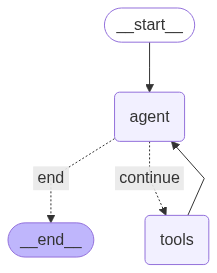

In [11]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))